<a href="https://colab.research.google.com/github/NelsonPixels/TensorFlow-CheatSheet/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [7]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split=['train','test[:50%]','test[50%:]'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2L7JKX/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2L7JKX/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2L7JKX/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for review,label in train_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [ ]:
def standardization(input_data):
  lower_case = tf.strings.lower(input_data)
  no_tag = tf.strings.regex_replace(lower_case,"<[^>]+>","")
  output = tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")
  return output

In [ ]:
standardization(tf.constant("We live in a CRAZY world<br><br />"))

<tf.Tensor: shape=(), dtype=string, numpy=b'we live in a crazy world'>

In [ ]:
from nltk.stem.porter import PorterStemmer

In [ ]:
PorterStemmer().stem("discussion")

'discuss'

In [9]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 200

In [ ]:
vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens= VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length= SEQUENCE_LENGTH
)



In [ ]:
#lengths = []
#words = []

#for review,label in train_ds.take(10):
#  for word in tf.strings.split(review, sep=''):
#    if word in words:
#      pass
#    else:
#      words.append(word)
#  lengths.append(len(tf.strings.split(review, sep='')))

In [ ]:
training_data = train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [ ]:
vectorize_layer.get_vocabulary()[10]

'this'

In [ ]:
for review, label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
def vectorizer(review,label):
  return vectorize_layer(review), label


In [ ]:
train_dataset = train_ds.map(vectorizer)
val_dataset = val_ds.map(vectorizer)

In [ ]:
for review, label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Modelling

In [ ]:
inputs = np.random.random([32,10,8]) #batch size, sequence length, vocabulary size
simple_rnn = tf.keras.layers.SimpleRNN(4) # if you want your model to be larger, you increase this
output = simple_rnn(inputs)
print(output.shape)

(32, 4)


In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h$'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset.take(10),
    epochs=10,
    callbacks=[model_checkpoint_callback]
    )

Epoch 1/10
258/391 [==================>...........] - ETA: 1:15 - loss: 0.7016 - accuracy: 0.5058

KeyboardInterrupt: ignored

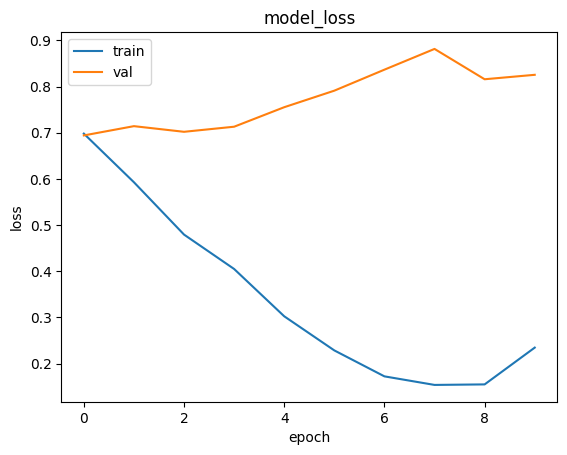

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

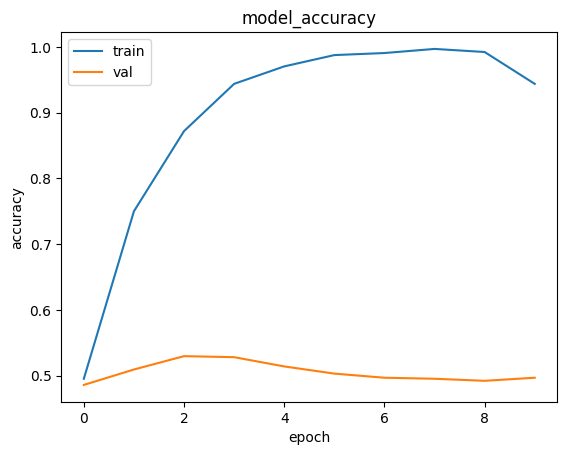

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

LSTM (Multilayer and Biderectional)

In [11]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model.summary()
## compile and train. Plot the graph to see the trend

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

GRU(Multilayer and Bidirectional)

In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model.summary()
## compile and train. Plot the graph to see the trend

Conv1D

In [13]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32,3,activation='relu'),
    Flatten(),
    Dense(32,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model.summary()
## compile and train. Plot the graph to see the trend

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 32)           6176      
                                                                 
 flatten_1 (Flatten)         (None, 6336)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                202784    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 848993 (3.24 MB)
Trainable params: 84899